In [19]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse import load_npz
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_train_tfidf = load_npz('trained_weights/tfidf/X_train_tfidf.npz')
X_test_tfidf = load_npz('trained_weights/tfidf/X_test_tfidf.npz')
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

y_train = np.load('trained_weights/tfidf/y_train.npy')
y_test = np.load('trained_weights/tfidf/y_test.npy')

In [9]:
x_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)


train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.a = nn.Linear(5000,2000)
        self.b = nn.Linear(2000,500)
        self.fc1 = nn.Linear(500, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.a(x))
        x = self.relu(self.b(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x
    
# Instantiate the model, define loss function, and optimizer
model = DeepNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

     # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        predictions = []

        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
            predicted = (outputs > 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / total

        # Calculate precision, recall, and F1 score
        y_true = y_test
        y_pred = predictions
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')



Epoch 1/3, Loss: 0.0181, Val Loss: 0.0867, Val Acc: 0.9657, Precision: 0.9517, Recall: 0.9609, F1 Score: 0.9563
Epoch 2/3, Loss: 0.0000, Val Loss: 0.0979, Val Acc: 0.9713, Precision: 0.9536, Recall: 0.9739, F1 Score: 0.9637
Epoch 3/3, Loss: 0.0000, Val Loss: 0.1370, Val Acc: 0.9611, Precision: 0.9659, Recall: 0.9334, F1 Score: 0.9494


In [ ]:
confusion_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
cm_display.plot()
plt.show() 

/home/andrew/dev/cs491ml/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


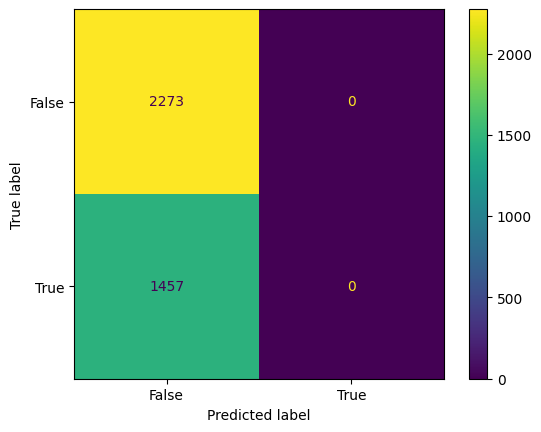

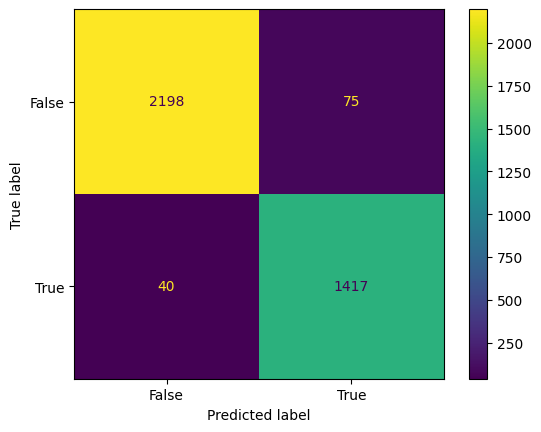

Epoch 1/3, Loss: 0.6845, Val Loss: 0.0833, Val Acc: 0.9692, Precision: 0.9497, Recall: 0.9725, F1 Score: 0.9610


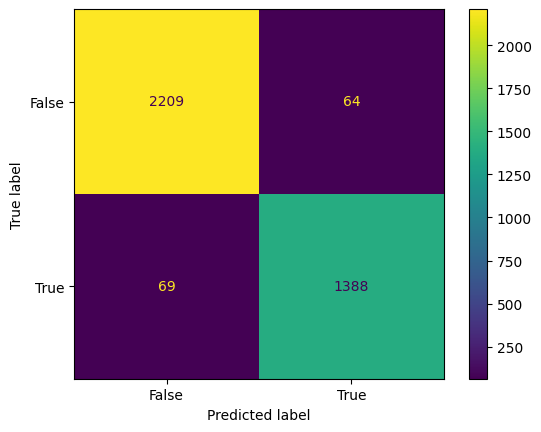

Epoch 2/3, Loss: 0.0065, Val Loss: 0.1093, Val Acc: 0.9643, Precision: 0.9559, Recall: 0.9526, F1 Score: 0.9543


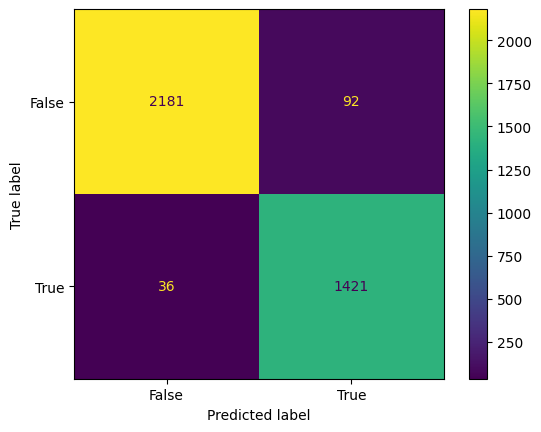

Epoch 3/3, Loss: 0.0096, Val Loss: 0.1153, Val Acc: 0.9657, Precision: 0.9392, Recall: 0.9753, F1 Score: 0.9569


In [22]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.a = nn.Linear(5000,2000)
        self.b = nn.Linear(2000,500)
        self.fc1 = nn.Linear(500, 256)
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.a(x))
        x = self.relu(self.b(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
# Instantiate the model, define loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model.eval()
with torch.no_grad():
    val_loss = 0.0
    correct = 0
    total = 0
    predictions = []

    for inputs, labels in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
        predicted = (outputs > 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Calculate precision, recall, and F1 score
    y_true = y_test
    y_pred = predictions
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

     # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        predictions = []

        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
            predicted = (outputs > 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / total

        # Calculate precision, recall, and F1 score
        y_true = y_test
        y_pred = predictions
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True]) 
        cm_display.plot()
        plt.show() 

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')



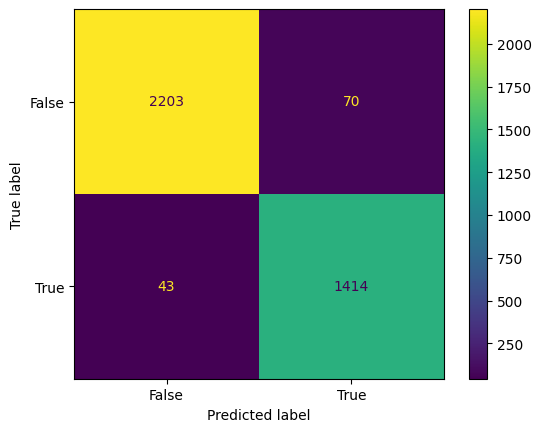

In [20]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True]) 
cm_display.plot()
plt.show() 

In [13]:
torch.save(model.state_dict(), 'trained_weights/emails.pth')

In [ ]:
"""
500
Epoch 1/10, Loss: 0.0631, Val Loss: 0.1580, Val Acc: 0.9335, Precision: 0.8938, Recall: 0.9417, F1 Score: 0.9171
Epoch 2/10, Loss: 0.0010, Val Loss: 0.1454, Val Acc: 0.9424, Precision: 0.9146, Recall: 0.9403, F1 Score: 0.9272
Epoch 3/10, Loss: 0.0274, Val Loss: 0.1310, Val Acc: 0.9466, Precision: 0.9037, Recall: 0.9664, F1 Score: 0.9340
Epoch 4/10, Loss: 0.0033, Val Loss: 0.1528, Val Acc: 0.9504, Precision: 0.9218, Recall: 0.9540, F1 Score: 0.9376
Epoch 5/10, Loss: 0.0029, Val Loss: 0.2153, Val Acc: 0.9440, Precision: 0.9376, Recall: 0.9176, F1 Score: 0.9275
Epoch 6/10, Loss: 0.0117, Val Loss: 0.2795, Val Acc: 0.9458, Precision: 0.9072, Recall: 0.9595, F1 Score: 0.9326
Epoch 7/10, Loss: 0.0491, Val Loss: 0.2605, Val Acc: 0.9493, Precision: 0.9238, Recall: 0.9485, F1 Score: 0.9360
Epoch 8/10, Loss: 0.0001, Val Loss: 0.3224, Val Acc: 0.9496, Precision: 0.9183, Recall: 0.9561, F1 Score: 0.9368
Epoch 9/10, Loss: 0.0019, Val Loss: 0.2844, Val Acc: 0.9493, Precision: 0.9188, Recall: 0.9547, F1 Score: 0.9364
Epoch 10/10, Loss: 0.0019, Val Loss: 0.3179, Val Acc: 0.9437, Precision: 0.9388, Recall: 0.9156, F1 Score: 0.9270

5000
Epoch 1/3, Loss: 0.0851, Val Loss: 0.0807, Val Acc: 0.9694, Precision: 0.9522, Recall: 0.9705, F1 Score: 0.9613
Epoch 2/3, Loss: 0.0151, Val Loss: 0.0889, Val Acc: 0.9710, Precision: 0.9567, Recall: 0.9698, F1 Score: 0.9632
Epoch 3/3, Loss: 0.0704, Val Loss: 0.1619, Val Acc: 0.9670, Precision: 0.9645, Recall: 0.9506, F1 Score: 0.9575

Epoch 1/3, Loss: 0.0950, Val Loss: 0.0901, Val Acc: 0.9668, Precision: 0.9593, Recall: 0.9554, F1 Score: 0.9574
Epoch 2/3, Loss: 0.0002, Val Loss: 0.1028, Val Acc: 0.9676, Precision: 0.9613, Recall: 0.9554, F1 Score: 0.9583
Epoch 3/3, Loss: 0.0621, Val Loss: 0.1219, Val Acc: 0.9689, Precision: 0.9509, Recall: 0.9705, F1 Score: 0.9606


5000 no punycode
similar

5000 simpler arch
Epoch 1/3, Loss: 0.0061, Val Loss: 0.0825, Val Acc: 0.9718, Precision: 0.9537, Recall: 0.9753, F1 Score: 0.9644
Epoch 2/3, Loss: 0.0095, Val Loss: 0.0942, Val Acc: 0.9694, Precision: 0.9474, Recall: 0.9760, F1 Score: 0.9615
Epoch 3/3, Loss: 0.0003, Val Loss: 0.1237, Val Acc: 0.9697, Precision: 0.9528, Recall: 0.9705, F1 Score: 0.9616 

"""